# Demographcis of the NSRR training/testing sets

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sns.set(style="ticks", font_scale=1.25)

from helper_functions import mean_std

# Define paths
wdir_demo = "output/demo/"
outdir = "output/plots/"

## Data loading

In [2]:
# First, let's merge with the main demographics
df_demo = pd.read_csv(wdir_demo + "demo_nsrr_all.csv")

print(df_demo.shape)
print(df_demo['set'].value_counts())
df_demo.head()

(3881, 13)
training    3281
testing      600
Name: set, dtype: int64


,dataset,subj,age,male,bmi,ahi,ethnicity,set,depression,diabete,hypertension,insomnia,narcolepsy
0,CCSHS,1800001,17,0,19.089716,0.244898,caucasian,training,0.0,0.0,0.0,NaN,NaN
1,CCSHS,1800005,17,1,29.338584,0.239521,caucasian,testing,1.0,0.0,0.0,NaN,NaN
2,CCSHS,1800007,18,1,35.897564,1.846154,african,training,0.0,0.0,0.0,NaN,NaN
3,CCSHS,1800013,18,1,21.176986,0.113636,caucasian,training,0.0,0.0,0.0,NaN,NaN
4,CCSHS,1800014,17,0,33.587853,1.901408,african,training,0.0,0.0,0.0,NaN,NaN


### Training set

In [3]:
df_training = pd.read_parquet("output/features/features_all.parquet", columns=['age']).reset_index()
print(df_training['subj'].nunique(), 'subjects')
print(df_training.shape)
df_training.head().round(2)

3163 subjects
(3807207, 3)


,subj,epoch,age
0,300001,0,8
1,300001,1,8
2,300001,2,8
3,300001,3,8
4,300001,4,8


### Testing set

In [4]:
# Choose model
model = "eeg+eog+emg+demo"
feat_files = glob.glob("output/cv/%s/cv_loo_nsrr_*.parquet" % model)

df_testing = []
for f in feat_files:
    df_testing.append(pd.read_parquet(f))
    
df_testing = pd.concat(df_testing)
df_testing['subj'] = df_testing['subj'].astype(str)
df_testing['dataset'] = df_testing['dataset'].str.upper()

# To avoid invalid F1, we remove subjects that do not have all sleep stages in original scoring
n_stage_per_subj = df_testing.groupby('subj')['y_true'].nunique()
bad_ss = n_stage_per_subj[n_stage_per_subj != 5].index
df_testing = df_testing[~df_testing['subj'].isin(bad_ss)].reset_index(drop=True)

print(df_testing['subj'].nunique(), 'subjects')
print(df_testing.shape)
df_testing.head().round(2)

561 subjects
(687947, 14)


,subj,model,age,male,y_true,y_pred,y_pred_second,confidence,proba_N1,proba_N2,proba_N3,proba_R,proba_W,dataset
0,300002,eeg+eog+emg+demo,9,0,W,W,N1,0.99,0.01,0.0,0.0,0.0,0.99,CHAT
1,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
2,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
3,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT
4,300002,eeg+eog+emg+demo,9,0,W,W,N1,1.00,0.00,0.0,0.0,0.0,1.00,CHAT


In [5]:
# Keep index of subjects included in the training/testing set
idx_training = df_training['subj'].unique().tolist()
idx_testing = df_testing['subj'].unique().tolist()
df_demo = df_demo[df_demo['subj'].isin(idx_training + idx_testing)].reset_index(drop=True)

# Add apnea severity
df_demo['apnea'] = pd.cut(
    df_demo['ahi'], bins=[0, 5, 15, 30, np.inf], right=False, include_lowest=True, 
    labels=["None", "Mild", "Moderate", "Severe"])

df_demo.round(2)

,dataset,subj,age,male,bmi,ahi,ethnicity,set,depression,diabete,hypertension,insomnia,narcolepsy,apnea
0,CCSHS,1800001,17,0,19.09,0.24,caucasian,training,0.0,0.0,0.0,NaN,NaN,None
1,CCSHS,1800005,17,1,29.34,0.24,caucasian,testing,1.0,0.0,0.0,NaN,NaN,None
2,CCSHS,1800007,18,1,35.90,1.85,african,training,0.0,0.0,0.0,NaN,NaN,None
3,CCSHS,1800013,18,1,21.18,0.11,caucasian,training,0.0,0.0,0.0,NaN,NaN,None
4,CCSHS,1800014,17,0,33.59,1.90,african,training,0.0,0.0,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,SHHS,205792,55,1,37.39,25.10,caucasian,training,NaN,0.0,1.0,NaN,NaN,Moderate
3720,SHHS,205794,65,0,22.31,3.26,caucasian,training,NaN,0.0,0.0,NaN,NaN,None
3721,SHHS,205799,54,0,32.41,3.29,caucasian,training,NaN,0.0,0.0,NaN,NaN,None
3722,SHHS,205800,66,1,25.69,53.54,caucasian,training,NaN,0.0,0.0,NaN,NaN,Severe


In [6]:
# Optional: remove HOMEPAP
# df_demo = df_demo[~df_demo['dataset'].isin(['HOMEPAP'])].reset_index(drop=True)

********

## Descriptive statistics

In [7]:
grp_set = df_demo.groupby("set")

### Continuous variable

In [8]:
# Number of nights
grp_set['age'].count()

set
testing      561
training    3163
Name: age, dtype: int64

In [9]:
table_desc = grp_set[['age', 'bmi', 'ahi']].agg(mean_std).T

for dv in table_desc.index:
    tt = df_demo.pairwise_ttests(dv=dv, between="set")
    table_desc.loc[dv, 'T'] = tt.loc[0, 'T']
    table_desc.loc[dv, 'dof'] = tt.loc[0, 'dof']
    table_desc.loc[dv, 'p-unc'] = tt.loc[0, 'p-unc']
    table_desc.loc[dv, 'hedges'] = tt.loc[0, 'hedges']

table_desc.round(3)

set,testing,training,T,dof,p-unc,hedges
age,44.19 ± 28.18,49.79 ± 26.38,-4.379,744.504,0.000,-0.210
bmi,26.73 ± 7.39,27.65 ± 7.40,-2.721,770.808,0.007,-0.125
ahi,11.39 ± 14.22,12.94 ± 16.35,-2.331,845.278,0.020,-0.097


#### Age

mean    std  min  max
set      dataset                        
testing  CCSHS    17.77   0.53   17   19
         CFS      40.11  18.71   11   79
         CHAT      6.65   1.49    5   10
         MESA     69.64   9.38   56   90
         MROS     76.20   5.55   69   90
         SHHS     62.94  11.05   42   87
training CCSHS    17.75   0.57   16   20
         CFS      41.14  19.35    7   89
         CHAT      6.55   1.39    5   10
         HOMEPAP  47.11  11.94   20   80
         MESA     68.93   9.04   55   93
         MROS     76.18   5.41   67   90
         SHHS     63.05  11.06   40   90

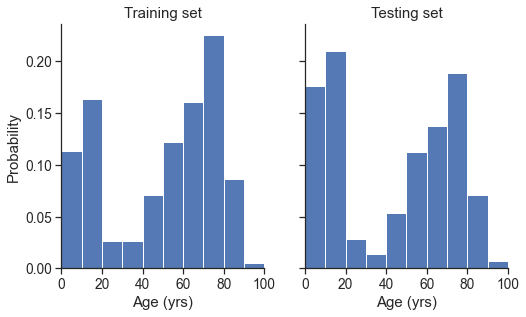

In [10]:
display(df_demo.groupby(['set', 'dataset'])['age'].agg(['mean', 'std', 'min', 'max']).round(2))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharey=True, sharex=True)
sns.histplot(df_demo[df_demo['set'] == 'training']['age'], 
             bins=np.linspace(0, 100, 11), stat='probability', alpha=0.95, ax=ax1)
sns.histplot(df_demo[df_demo['set'] == 'testing']['age'], 
             bins=np.linspace(0, 100, 11), stat='probability', alpha=0.95, ax=ax2)

ax1.set_xlabel("Age (yrs)")
ax2.set_xlabel("Age (yrs)")

ax1.set_title("Training set")
ax2.set_title("Testing set")

plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100])

sns.despine()

plt.savefig(outdir + "hist_age.png", dpi=300, bbox_inches="tight")

#### AHI

In [11]:
df_demo.groupby(['set', 'dataset'])['ahi'].agg(['mean', 'std', 'min', 'max']).round(2)

mean    std   min     max
set      dataset                            
testing  CCSHS     1.35   2.63  0.00   19.49
         CFS      10.18  16.77  0.00  102.65
         CHAT      6.88   5.55  1.40   29.33
         MESA     20.32  19.06  0.00  110.33
         MROS     17.14  13.37  0.00   53.00
         SHHS     14.28  12.06  0.18   59.40
training CCSHS     1.48   5.23  0.00   99.13
         CFS      13.44  20.65  0.00  125.07
         CHAT      6.76   5.84  0.17   32.43
         HOMEPAP  15.99  19.93  0.32   90.20
         MESA     19.24  18.09  0.00  111.28
         MROS     16.80  14.95  0.00   76.00
         SHHS     13.90  14.63  0.00   70.89

### Categorical variables

In [12]:
def value_counts_chi2(dv, normalize=True):
    """Show value counts and chi-square test.
    
    NaN values are droppped by chi2_independence (see pd.crosstab)"""
    if normalize:
        display(100 * grp_set[dv].value_counts(normalize=normalize, sort=False).round(5))
    else:
        display(grp_set[dv].value_counts(sort=False).round(5))
    print("")
    display(pg.chi2_independence(df_demo, x=dv, y='set', correction=True)[2].iloc[0, :])

In [13]:
# Sex and chi2-test
value_counts_chi2("male")

set       male
testing   0       45.811
          1       54.189
training  0       43.440
          1       56.560
Name: male, dtype: float64

test       pearson
lambda         1.0
chi2      0.994261
dof            1.0
pval      0.318703
cramer     0.01634
power     0.169367
Name: 0, dtype: object

In [14]:
# Ethnicity
value_counts_chi2("ethnicity")

set       ethnicity
testing   african      28.877
          caucasian    59.002
          hispanic      6.952
          other         5.169
training  african      29.466
          caucasian    57.920
          hispanic      7.240
          other         5.375
Name: ethnicity, dtype: float64

test       pearson
lambda         1.0
chi2      0.244804
dof            3.0
pval      0.970051
cramer    0.008108
power     0.064769
Name: 0, dtype: object

In [15]:
# Dataset
value_counts_chi2("dataset")

set       dataset
testing   CCSHS      17.825
          CFS        16.399
          CHAT       17.825
          MESA       16.043
          MROS       15.152
          SHHS       16.756
training  CCSHS      13.089
          CFS        18.527
          CHAT       11.097
          HOMEPAP     2.592
          MESA       18.179
          MROS       17.863
          SHHS       18.653
Name: dataset, dtype: float64

/Users/raphael/GitHub/pingouin/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/stats/stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


test        pearson
lambda          1.0
chi2      45.442462
dof             6.0
pval            0.0
cramer     0.110465
power      0.999892
Name: 0, dtype: object

In [16]:
# Apnea severity
value_counts_chi2("apnea")

set               
testing   None        45.098
          Mild        26.916
          Moderate    18.004
          Severe       9.982
training  None        42.776
          Mild        27.790
          Moderate    17.325
          Severe      12.109
Name: apnea, dtype: float64

test       pearson
lambda         1.0
chi2      2.681084
dof            3.0
pval      0.443451
cramer    0.026832
power     0.248009
Name: 0, dtype: object

In [17]:
# Insomnia
value_counts_chi2("insomnia")

set       insomnia
testing   0.0         96.277
          1.0          3.723
training  0.0         93.049
          1.0          6.951
Name: insomnia, dtype: float64

test       pearson
lambda         1.0
chi2      2.275025
dof            1.0
pval      0.131473
cramer    0.024717
power     0.326024
Name: 0, dtype: object

In [18]:
# Narcolepsy
value_counts_chi2("narcolepsy")

set       narcolepsy
testing   0.0           100.000
training  0.0            99.169
          1.0             0.831
Name: narcolepsy, dtype: float64

/Users/raphael/GitHub/pingouin/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))


test       pearson
lambda         1.0
chi2      0.056366
dof            1.0
pval      0.812335
cramer     0.00389
power     0.056482
Name: 0, dtype: object

In [19]:
# Depression
value_counts_chi2("depression")

set       depression
testing   0.0           86.885
          1.0           13.115
training  0.0           84.171
          1.0           15.829
Name: depression, dtype: float64

test       pearson
lambda         1.0
chi2       0.68501
dof            1.0
pval      0.407867
cramer    0.013563
power     0.131407
Name: 0, dtype: object

In [20]:
# Diabetes
value_counts_chi2("diabete")

set       diabete
testing   0.0        82.418
          1.0        17.582
training  0.0        84.184
          1.0        15.816
Name: diabete, dtype: float64

test       pearson
lambda         1.0
chi2      0.777579
dof            1.0
pval      0.377883
cramer     0.01445
power     0.142724
Name: 0, dtype: object

In [21]:
# Hypertension
value_counts_chi2("diabete")

set       diabete
testing   0.0        82.418
          1.0        17.582
training  0.0        84.184
          1.0        15.816
Name: diabete, dtype: float64

test       pearson
lambda         1.0
chi2      0.777579
dof            1.0
pval      0.377883
cramer     0.01445
power     0.142724
Name: 0, dtype: object